<div style="border: 5px solid purple; padding: 15px; margin: 5px">
<b> Reviewer's comment 2 </b>
    
Thank you for your diligence! I've left a couple of new comments with digit 2, but there's nothing that needs to be fixed.
    
    
You did a fantastic job here. You have correctly split the data, explored the distributions, trained several models, and applied the bootstrapping technique. You have successfully estimated profit and conducted risk analysis. You have also compared regions based on risk-adjusted return to make recommendations for further development. Excellent job! 
    
    
I do not have any questions, so the project can be accepted. The next sprints will cover more advanced machine learning methods, I hope you will like it. Good luck! 
    
    

</div>

<div style="border: 5px solid purple; padding: 15px; margin: 5px">
<b> Reviewer's comment</b>
    
Hi! My name is Svetlana. Congratulations on submitting another project! 🎉
    

Before we start, I want to pay your attention to the color marking:


<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b> Reviewer's comment </b>

    
Great solutions and ideas that can and should be used in the future are in green comments. Some of them are: 
    
    
- You have successfully prepared the subsets. It is important to split the data correctly in order to ensure there's no intersection;    
    

- Used linear regression to make predictions;
    
    
- Calculated profit and estimated risk values; 
    
    
</div>
    
<div style="border: 5px solid gold; padding: 15px; margin: 5px">
<b> Reviewer's comment </b>

Yellow color indicates what should be optimized. This is not necessary, but it will be great if you make changes to this project. I've left several recommendations throughout the project. 
    
</div>
<div style="border: 5px solid red; padding: 15px; margin: 5px">
<b> Reviewer's comment </b>

Issues that must be corrected to achieve accurate results are indicated in red comments. Please note that the project cannot be accepted until these issues are resolved.
</div>        
<hr>
    
<font color='dodgerblue'>**To sum up:**</font> you did a great job here, thank you so much for submitting the project! Actually the project is almost perfect, and the updates should not take much time. If you have any questions, please feel free to ask. I will wait the project for the second review 😊 
    

<hr>
    
Please use some color other than those listed to highlight answers to my comments.
I would also ask you **not to change, move or delete my comments** to make it easier for me to navigate during the next review.
    
<hr> 
    
✍️ Here's a nice [article](https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/) about the bootstrap method. [This](https://www.youtube.com/watch?v=O_Fj4q8lgmc&list=LL&index=6) is a good video about resampling in bootstrapping.
    
<hr>
    
    
📌 Please feel free to schedule a 1:1 sessions with our tutors or TAs [here](https://calendly.com/tripleten-ds-experts-team), join daily coworking sessions, or ask questions on TripleTen Hub if you need assistance 😉 
</div>

This notebook walks through the full project step by step with simple code:
1) Load & prepare data for **three regions**  
2) Train **Linear Regression** (75/25 split) and evaluate RMSE  
3) Prepare for profit calculation (business rules)  
4) Write a **profit function** that picks top 200 predicted wells out of 500 explored  
5) Use **bootstrapping (1000 runs)** to estimate average profit, 95% confidence interval, and risk of loss  
6) Recommend the best region if risk < 2.5%

In [1]:
# 0) Imports & constants
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
RANDOM_STATE = 12345

# Business conditions
BUDGET = 100_000_000          # $100M to develop 200 wells
WELLS_TO_DEVELOP = 200        # select top 200 wells
POINTS_EXPLORED = 500         # we explore 500 points in a region
REVENUE_PER_UNIT = 4_500      # $ per 1000 barrels (product column is in thousand barrels)

# Data files 
DATA_FILES = {
    'region_0': '/datasets/geo_data_0.csv',
    'region_1': '/datasets/geo_data_1.csv',
    'region_2': '/datasets/geo_data_2.csv',
}

print('Working directory:', os.getcwd())
print('Here are files next to the notebook:', os.listdir())

Working directory: /app
Here are files next to the notebook: ['eda_stats_all_regions.csv', '.ipynb_checkpoints', 'notebook.ipynb', 'Method_and_Findings.md']


<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Good! 
</div>

In [2]:
def load_region(path):
    """Load one region CSV. Expects columns: id, f0, f1, f2, product (thousand barrels)."""
    df = pd.read_csv(path)
    expected = {'id','f0','f1','f2','product'}
    missing = expected - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns {missing} in {path}")
    return df

regions = {}
for key, path in DATA_FILES.items():
    try:
        regions[key] = load_region(path)
        print(f"Loaded {key}: {path} with shape {regions[key].shape}")
    except Exception as e:
        print(f"Could not load {key} from {path}: {e}")
        print("If needed, update DATA_FILES with the correct paths.")

Loaded region_0: /datasets/geo_data_0.csv with shape (100000, 5)
Loaded region_1: /datasets/geo_data_1.csv with shape (100000, 5)
Loaded region_2: /datasets/geo_data_2.csv with shape (100000, 5)


In [3]:
APPLY_DEDUP = False

def duplicate_report_and_fix(regions_dict):
    cleaned = {}
    report_rows = []

    for key, df in regions_dict.items():
        n_rows = len(df)
        exact_dupes = int(df.duplicated().sum())
        id_dupes = int(df['id'].duplicated().sum())

        dup_id_rows = df[df['id'].duplicated(keep=False)].copy()

        # Count ids with conflicting rows: same id but rows differ in features/target
        conflicting_ids = 0
        if not dup_id_rows.empty:
            cols = ['f0', 'f1', 'f2', 'product']
            conflicts = dup_id_rows.groupby('id').apply(
                lambda g: g[cols].drop_duplicates().shape[0] > 1
            )
            conflicting_ids = int(conflicts.sum())

        # Cleaned version: drop exact dupes; then drop duplicate ids keeping first (deterministic)
        cleaned_df = (
            df.drop_duplicates()
              .sort_values('id')
              .drop_duplicates(subset=['id'], keep='first')
              .sort_index()
        )
        cleaned[key] = cleaned_df

        report_rows.append({
            'region': key,
            'rows': n_rows,
            'exact_duplicate_rows': exact_dupes,
            'duplicate_id_rows': id_dupes,
            'ids_with_conflicting_rows': conflicting_ids,
            'rows_after_cleaning': len(cleaned_df)
        })

    report_df = pd.DataFrame(report_rows).set_index('region')
    print("Duplicate summary (per region):")
    display(report_df)

    # Human-friendly yes/no summary
    for key, row in report_df.iterrows():
        dupes_present = (row['exact_duplicate_rows'] > 0) or (row['duplicate_id_rows'] > 0)
        conflicts_present = (row['ids_with_conflicting_rows'] > 0)
        print(f"\n[{key}] Duplicates present? {'YES' if dupes_present else 'NO'} | Conflicting ids? {'YES' if conflicts_present else 'NO'}")    

    # Sample of duplicate-id rows, if any
    for key, df in regions_dict.items():
        dup_id_rows = df[df['id'].duplicated(keep=False)]
        if not dup_id_rows.empty:
            print(f"\nSample duplicate-id rows in {key}: (showing up to 10)")
            display(dup_id_rows.sort_values('id').head(10))

    return cleaned, report_df

cleaned_regions, dupe_report_df = duplicate_report_and_fix(regions)

if APPLY_DEDUP:
    regions = cleaned_regions
    print("\nApplied de-duplication: replaced `regions` with cleaned copies.")
else:
    print("\nAPPLY_DEDUP=False — no changes applied. Set True to apply cleaning.")


Duplicate summary (per region):


,rows,exact_duplicate_rows,duplicate_id_rows,ids_with_conflicting_rows,rows_after_cleaning
region,,,,,
region_0,100000,0,10,10,99990
region_1,100000,0,4,4,99996
region_2,100000,0,4,4,99996



[region_0] Duplicates present? YES | Conflicting ids? YES

[region_1] Duplicates present? YES | Conflicting ids? YES

[region_2] Duplicates present? YES | Conflicting ids? YES

Sample duplicate-id rows in region_0: (showing up to 10)


,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502



Sample duplicate-id rows in region_1: (showing up to 10)


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305



Sample duplicate-id rows in region_2: (showing up to 10)


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641



APPLY_DEDUP=False — no changes applied. Set True to apply cleaning.


<div style="border: 5px solid red; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>


- Are there any duplicates?

  
- Let's analyze the distributions of features and targets in each dataframe.  Would you add charts? 


- Don't forget to add conclusions.
</div>


=== EDA for region_0 ===


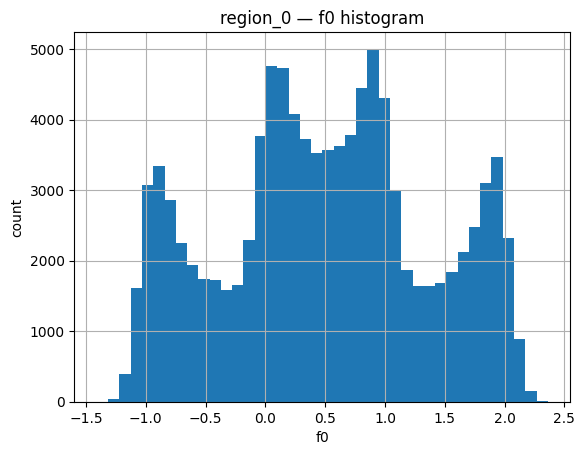

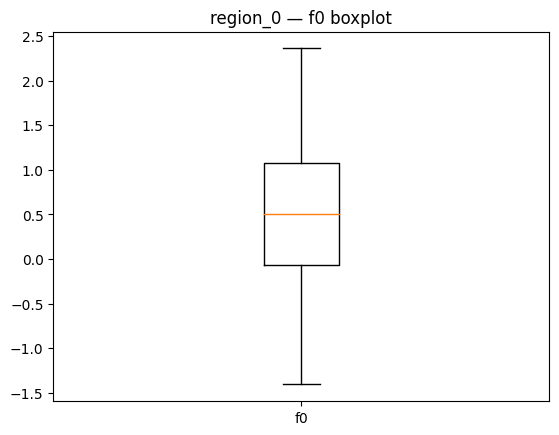

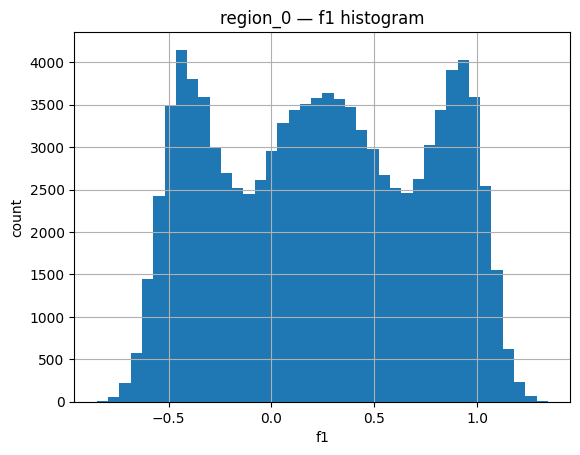

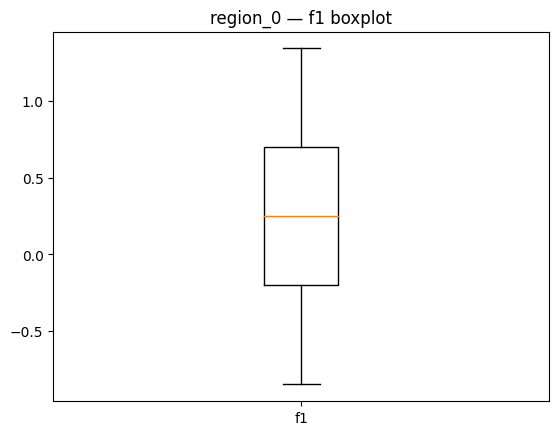

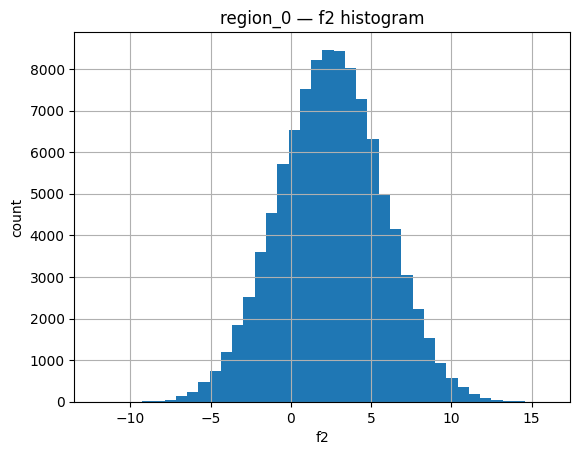

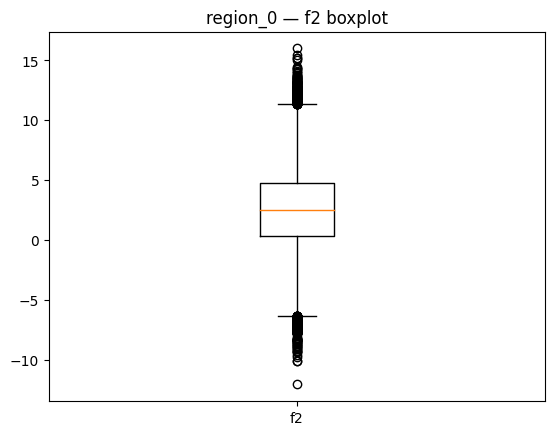

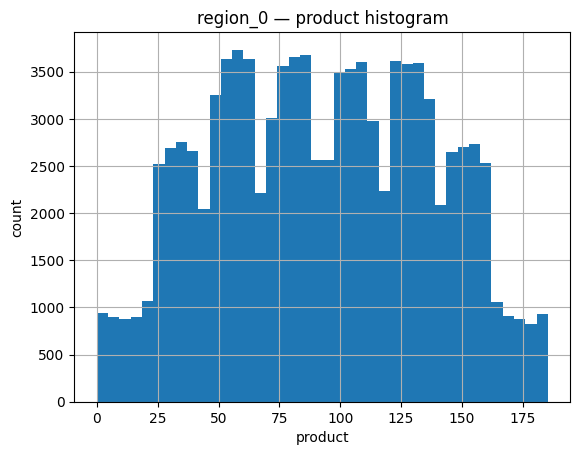

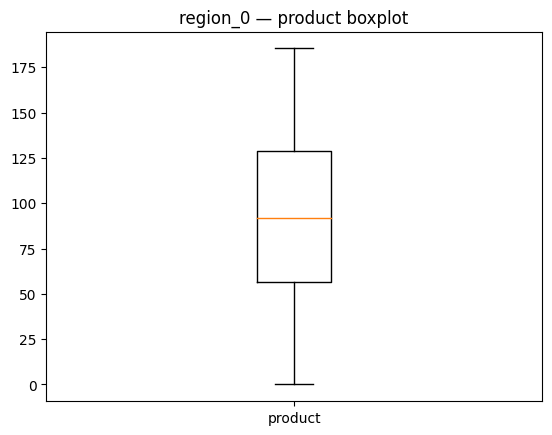

  region feature  count      mean    median       std        min        max      skew  kurtosis       IQR  outlier_share_IQR
region_0      f0 100000  0.500419  0.502360  0.871832  -1.408605   2.362331 -0.000337 -0.868909  1.146162            0.00000
region_0      f1 100000  0.250143  0.250252  0.504433  -0.848218   1.343769  0.000717 -1.186068  0.901528            0.00000
region_0      f2 100000  2.502647  2.515969  3.248248 -12.088328  16.003790 -0.002996 -0.111284  4.427340            0.00506
region_0 product 100000 92.500000 91.849972 44.288691   0.000000 185.364347  0.004816 -0.951506 72.066582            0.00000

=== EDA for region_1 ===


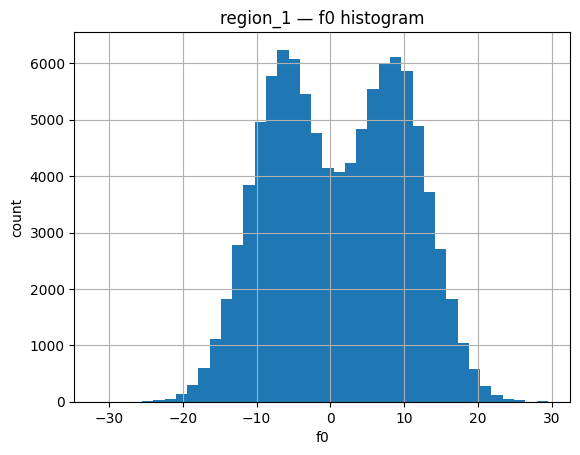

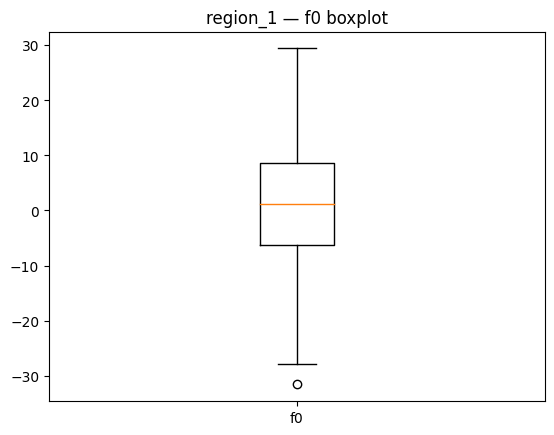

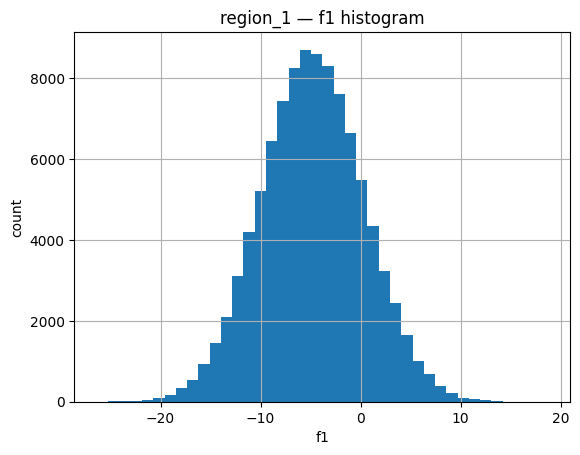

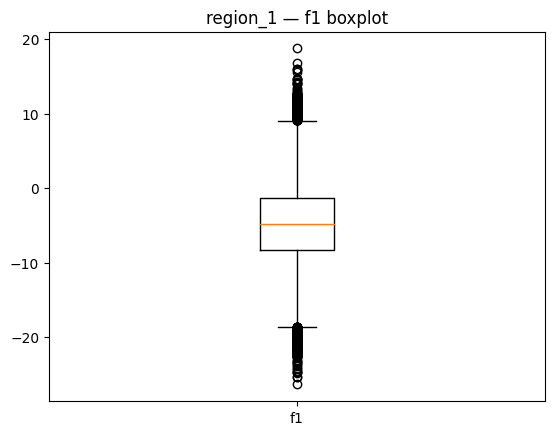

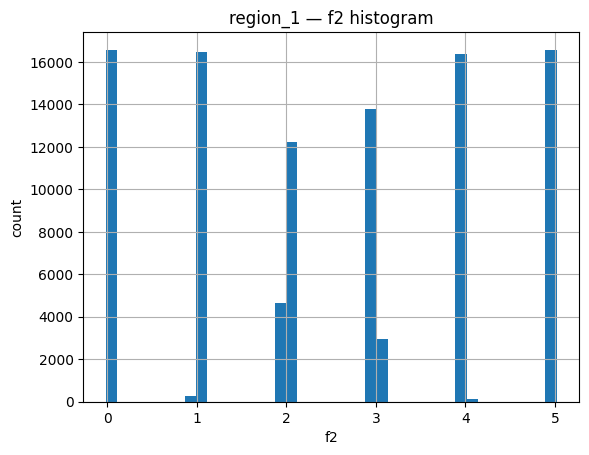

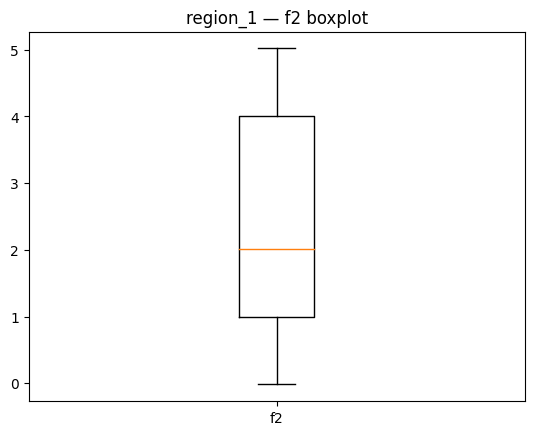

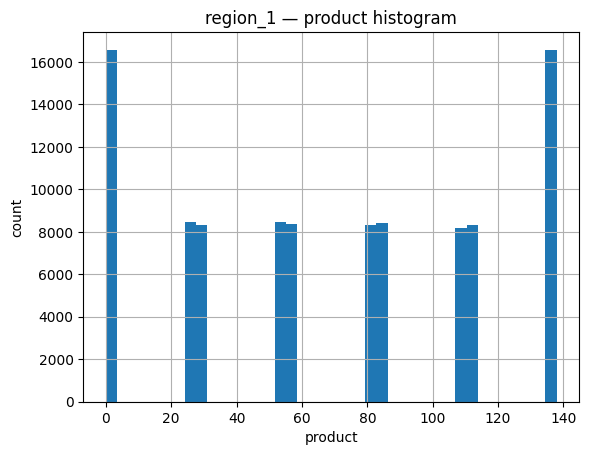

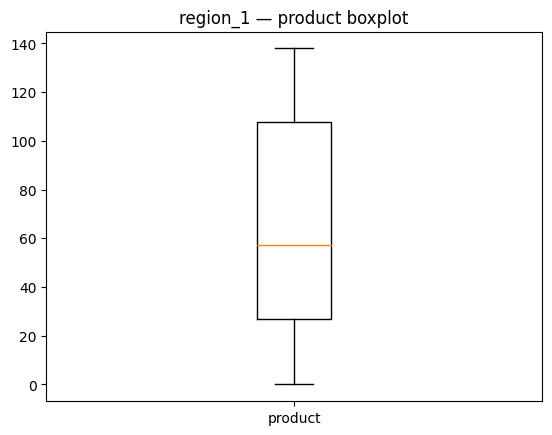

  region feature  count      mean    median       std        min        max     skew  kurtosis       IQR  outlier_share_IQR
region_1      f0 100000  1.141296  1.153055  8.965932 -31.609576  29.421755 0.001992 -0.947124 14.919567            0.00001
region_1      f1 100000 -4.796579 -4.813172  5.119872 -26.358598  18.734063 0.016597 -0.023065  6.935169            0.00636
region_1      f2 100000  2.494541  2.011479  1.703572  -0.018144   5.019721 0.006666 -1.261794  2.999883            0.00000
region_1 product 100000 68.825000 57.085625 45.944423   0.000000 137.945408 0.006685 -1.259374 80.859783            0.00000

=== EDA for region_2 ===


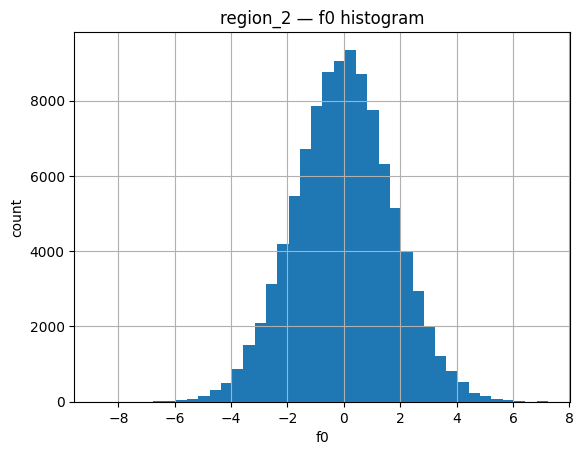

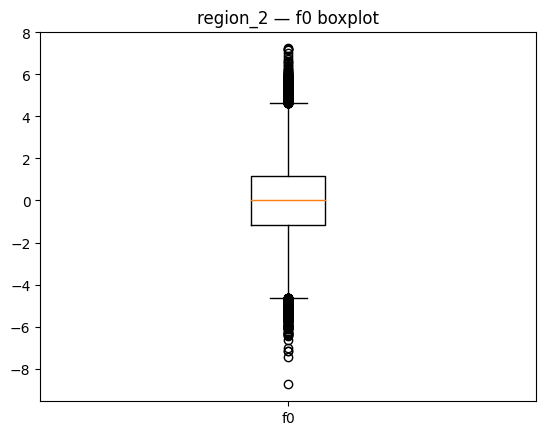

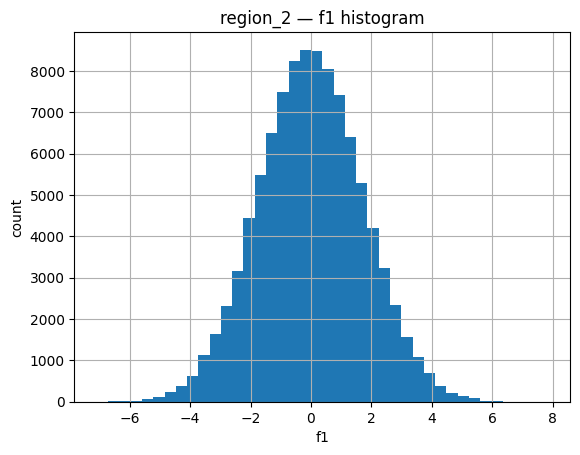

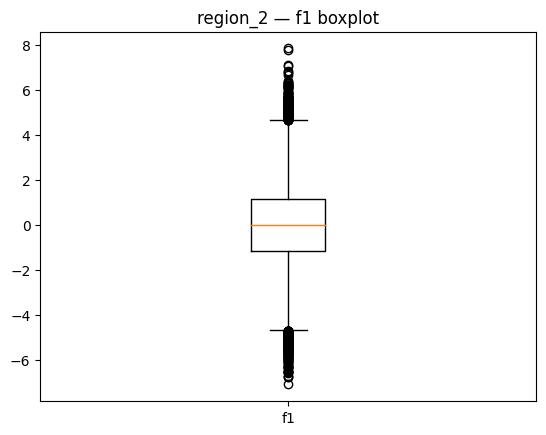

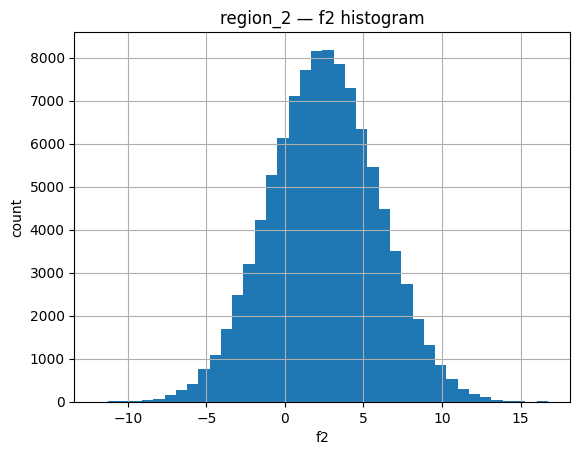

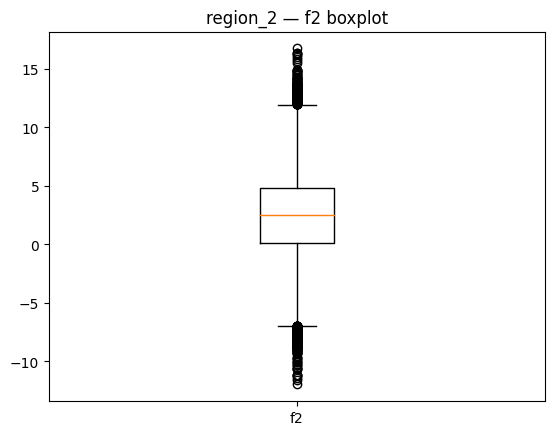

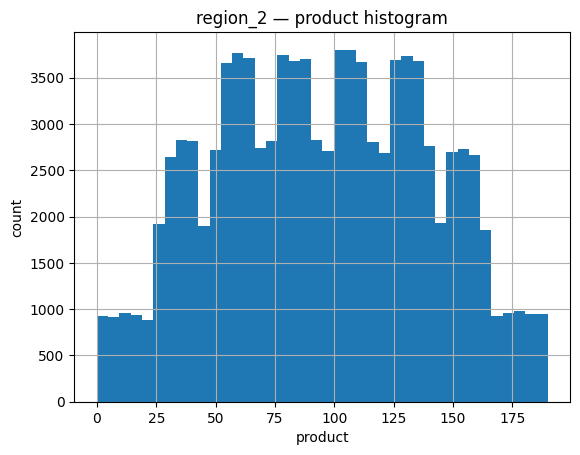

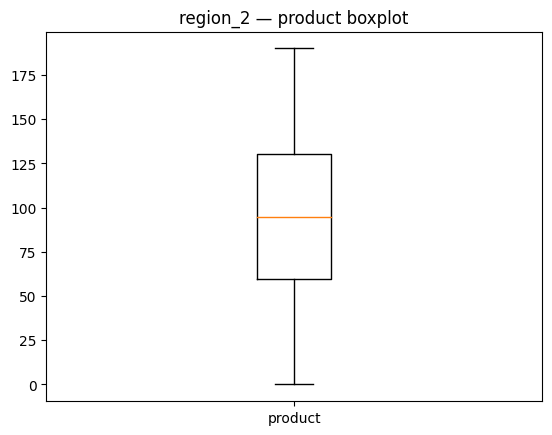

  region feature  count      mean    median       std        min        max     skew  kurtosis       IQR  outlier_share_IQR
region_2      f0 100000  0.002023  0.009424  1.732045  -8.760004   7.238262 0.003941  0.015364  2.320824            0.00733
region_2      f1 100000 -0.002081 -0.009482  1.730417  -7.084020   7.844801 0.014802 -0.012328  2.338497            0.00684
region_2      f2 100000  2.495128  2.484236  3.473445 -11.970335  16.739402 0.004057 -0.068082  4.728435            0.00584
region_2 product 100000 95.000000 94.925613 44.749921   0.000000 190.029838 0.004655 -0.878423 71.144586            0.00000

Saved combined EDA stats to: eda_stats_all_regions.csv


In [4]:



def iqr_outlier_share(s):
    s=s.dropna(); q1,q3=s.quantile(0.25), s.quantile(0.75); iqr=q3-q1
    if iqr==0: return 0.0, iqr
    lower, upper = q1-1.5*iqr, q3+1.5*iqr
    return float(((s<lower)|(s>upper)).mean()), float(iqr)

def region_eda(regions_dict, export_csv=True, csv_path='eda_stats_all_regions.csv'):
    all_stats=[]
    for k,df in regions_dict.items():
        print(f"\n=== EDA for {k} ===")
        for col in ['f0','f1','f2','product']:
            ser=df[col].astype(float)
            plt.figure(); ser.hist(bins=40); plt.title(f"{k} — {col} histogram"); plt.xlabel(col); plt.ylabel('count'); plt.show()
            plt.figure(); plt.boxplot(ser.dropna(), vert=True, labels=[col]); plt.title(f"{k} — {col} boxplot"); plt.show()
            out_share,iqr=iqr_outlier_share(ser)
            all_stats.append({'region':k,'feature':col,'count':int(ser.count()),'mean':float(ser.mean()),'median':float(ser.median()),'std':float(ser.std()),'min':float(ser.min()),'max':float(ser.max()),'skew':float(ser.skew()),'kurtosis':float(ser.kurtosis()),'IQR':iqr,'outlier_share_IQR':out_share})
        # print per-region table
        reg_df=pd.DataFrame([r for r in all_stats if r['region']==k])
        print(reg_df.to_string(index=False))
    combined=pd.DataFrame(all_stats)
    if export_csv:
        combined.to_csv(csv_path, index=False); print(f"\nSaved combined EDA stats to: {csv_path}")
    return combined

eda_stats=region_eda(regions)



region_0

Features: f0 (μ≈0.50), f1 (μ≈0.25), f2 (μ≈2.50) are near-symmetric (skew ~ 0), very low outlier share (0–0.5%).

Target (product): μ≈92.5, median≈91.85, σ≈44.29, IQR≈72.07; skew ~ 0 and essentially no outliers flagged.

Conclusion: Very clean, well-behaved distributions. No obvious data issues; variance is moderate.

region_1

Features: Much wider spread—f0 σ≈8.97, f1 σ≈5.12; small outlier shares (≤0.6%).

Target (product): μ≈68.83, median≈57.09 (noticeably below the mean), σ≈45.94, IQR≈80.86 (widest of all). Skew printed ~0, but the mean-vs-median gap hints at a long right tail.

Conclusion: This region has the widest target dispersion (most variability). Despite that, your model RMSE from validation was tiny here—so the signal is very linear/predictable (great for LR), even though the target is widely spread.

region_2

Features: Centered near 0 (for f0/f1) and ~2.5 for f2. Outlier shares ~0.6% or lower.

Target (product): μ≈95.0, median≈94.93, σ≈44.75, IQR≈71.14; near-symmetric and clean.

Conclusion: Similar cleanliness to region_0 but with a slightly higher mean target.



<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment 2 </b>
    
Excellent! Why is this important? In real-world problems, the data is rarely clean. Displaying distributions help us evaluate the data, find outliers, identify the required preprocessing steps and understand feature relationships, which informs feature engineering. Feature engineering in some cases is a clue.

</div>

In [5]:
def train_and_validate(df, random_state=RANDOM_STATE):
    X = df[['f0','f1','f2']].copy()
    y = df['product'].copy()

    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.25, random_state=random_state
    )

    model = LinearRegression()
    model.fit(X_train, y_train)

    preds_valid = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, preds_valid, squared=False)
    mean_pred = preds_valid.mean()

    # Save predictions & correct answers in a DataFrame
    results = pd.DataFrame({
        'pred': preds_valid,
        'target': y_valid.reset_index(drop=True)
    })
    return model, results, rmse, mean_pred



models = {}
valid_results = {}
metrics = {}

for key, df in regions.items():
    model, res, rmse, mean_pred = train_and_validate(df)
    models[key] = model
    valid_results[key] = res
    metrics[key] = {'rmse': rmse, 'mean_pred': mean_pred}
    print(f"[{key}] RMSE: {rmse:.3f} | Mean predicted reserves: {mean_pred:.3f} (thousand bbl)")

[region_0] RMSE: 37.579 | Mean predicted reserves: 92.593 (thousand bbl)
[region_1] RMSE: 0.893 | Mean predicted reserves: 68.729 (thousand bbl)
[region_2] RMSE: 40.030 | Mean predicted reserves: 94.965 (thousand bbl)


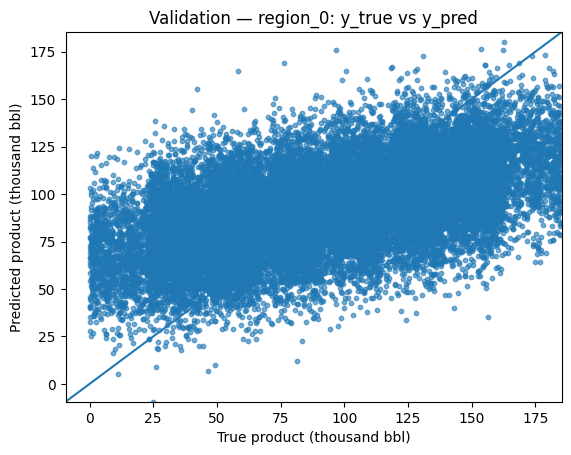

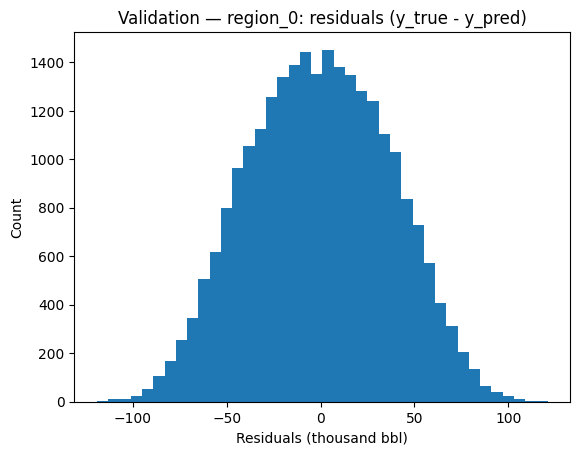


Sample predictions for region_0:
     pred     target
95.894952  10.038645
77.572583 114.551489
77.892640 132.603635
90.175134 169.072125
70.510088 122.325180


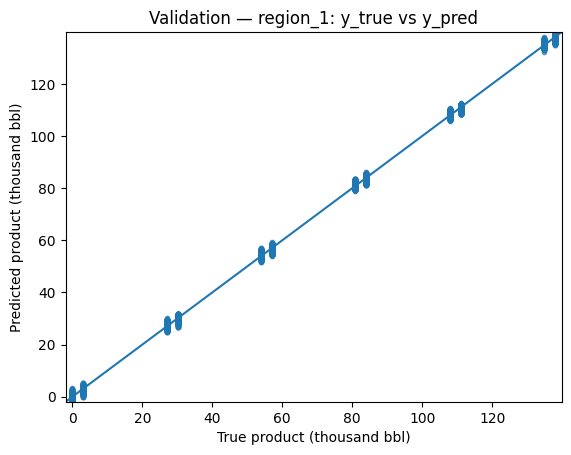

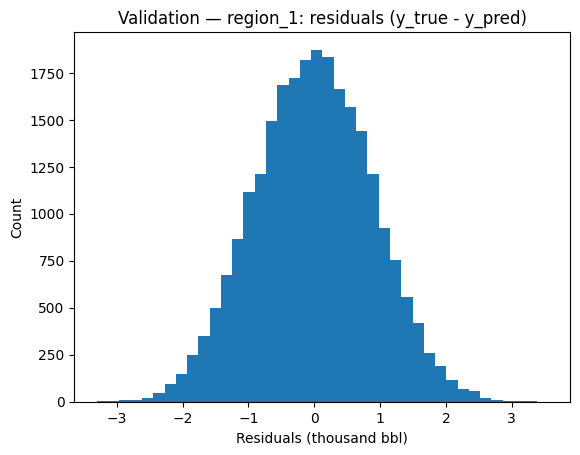


Sample predictions for region_1:
     pred    target
82.663314 80.859783
54.431786 53.906522
29.748760 30.132364
53.552133 53.906522
 1.243856  0.000000


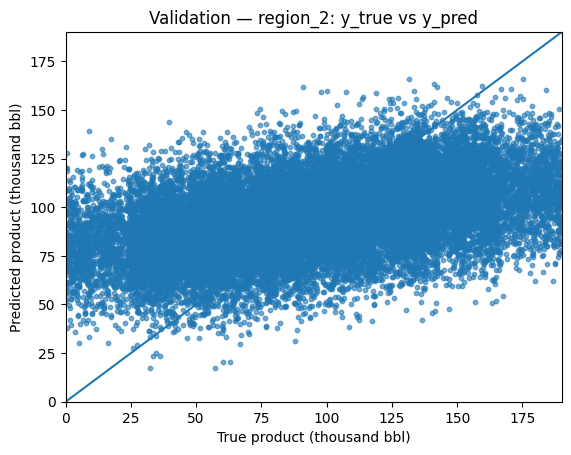

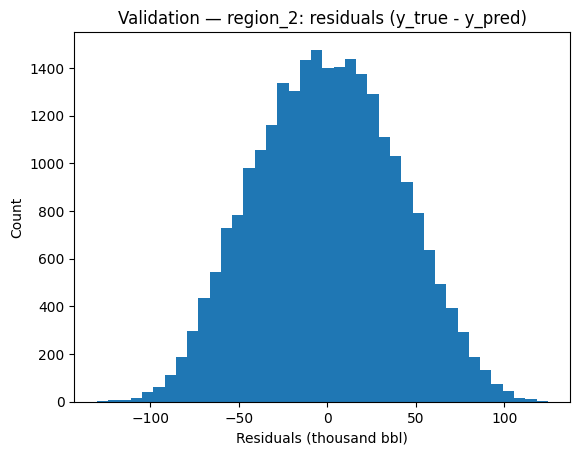


Sample predictions for region_2:
      pred     target
 93.599633  61.212375
 75.105159  41.850118
 90.066809  57.776581
105.162375 100.053761
115.303310 109.897122

=== Prediction Metrics (lower RMSE/MAE is better; higher R² is better) ===
           RMSE    MAE    R2  RMSE_baseline  MAE_baseline  R2_baseline
region                                                                
region_0 37.579 30.920 0.280         44.286        37.671        0.000
region_1  0.893  0.719 1.000         46.021        40.369        0.000
region_2 40.030 32.793 0.205         44.902        37.921        0.000

Best by RMSE: region_1 (RMSE = 0.893)
Best by R²:   region_1 (R² = 1.000)

Conclusion:
- The model should beat the constant baseline (lower RMSE/MAE, higher R²).
- Check scatter plots for tightness around y=x (good calibration).
- Residuals should be centered near 0 with a roughly symmetric shape.


In [6]:

def evaluate_predictions(valid_results_dict, title_prefix="Validation"):
    rows = []
    for key, df_res in valid_results_dict.items():
        y_true = df_res["target"].values
        y_pred = df_res["pred"].values

        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mae  = mean_absolute_error(y_true, y_pred)
        r2   = r2_score(y_true, y_pred)

        # Baseline: predict the validation mean (constant model)
        baseline = np.full_like(y_true, fill_value=y_true.mean(), dtype=float)
        rmse_base = mean_squared_error(y_true, baseline, squared=False)
        mae_base  = mean_absolute_error(y_true, baseline)
        r2_base   = r2_score(y_true, baseline)

        rows.append({
            "region": key,
            "RMSE": rmse,
            "MAE": mae,
            "R2": r2,
            "RMSE_baseline": rmse_base,
            "MAE_baseline": mae_base,
            "R2_baseline": r2_base
        })

        # ---- Plots ----
        # 1) y_true vs y_pred (ideal line y=x)
        plt.figure()
        plt.scatter(y_true, y_pred, s=10, alpha=0.6)
        lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
        plt.plot(lims, lims)  # y = x line
        plt.title(f"{title_prefix} — {key}: y_true vs y_pred")
        plt.xlabel("True product (thousand bbl)")
        plt.ylabel("Predicted product (thousand bbl)")
        plt.xlim(lims); plt.ylim(lims)
        plt.show()

        # 2) Residuals histogram
        residuals = y_true - y_pred
        plt.figure()
        plt.hist(residuals, bins=40)
        plt.title(f"{title_prefix} — {key}: residuals (y_true - y_pred)")
        plt.xlabel("Residuals (thousand bbl)")
        plt.ylabel("Count")
        plt.show()

        # Optional: peek at the first few predictions/targets
        print(f"\nSample predictions for {key}:")
        print(df_res.head(5).to_string(index=False))

    metrics_df = pd.DataFrame(rows).set_index("region")
    print("\n=== Prediction Metrics (lower RMSE/MAE is better; higher R² is better) ===")
    print(metrics_df.to_string(float_format=lambda x: f"{x:,.3f}"))

    # Quick textual summary / best performers
    best_rmse_region = metrics_df["RMSE"].idxmin()
    best_r2_region   = metrics_df["R2"].idxmax()
    print(f"\nBest by RMSE: {best_rmse_region} (RMSE = {metrics_df.loc[best_rmse_region, 'RMSE']:.3f})")
    print(f"Best by R²:   {best_r2_region} (R² = {metrics_df.loc[best_r2_region, 'R2']:.3f})")

    # Basic conclusion line you can paste in a report
    print("\nConclusion:")
    print("- The model should beat the constant baseline (lower RMSE/MAE, higher R²).")
    print("- Check scatter plots for tightness around y=x (good calibration).")
    print("- Residuals should be centered near 0 with a roughly symmetric shape.")
    return metrics_df

pred_metrics = evaluate_predictions(valid_results, title_prefix="Validation")

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
Correct! 

</div>
<div style="border: 5px solid red; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    

What about the predictions? Let's evaluate models' performance as well.
    
</div>

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment 2 </b>
    
So region 2 is the most profitable, but it has the highest model error at the same time. 

</div>

In [7]:
break_even_units = BUDGET / (WELLS_TO_DEVELOP * REVENUE_PER_UNIT)
print(f"Break-even reserves per developed well: {break_even_units:.2f} thousand barrels")  # units match 'product'

region_means = {k: v['product'].mean() for k, v in regions.items()}
print("Average reserves (thousand bbl) by region:")
for k, m in region_means.items():
    print(f" - {k}: {m:.2f}")

Break-even reserves per developed well: 111.11 thousand barrels
Average reserves (thousand bbl) by region:
 - region_0: 92.50
 - region_1: 68.83
 - region_2: 95.00


Break-even is ~111.11k bbl per developed well.
All three regions’ means (92.5k, 68.83k, 95k) are below this.
➜ If you drilled wells at random, you’d expect losses in every region.

<div style="border: 5px solid green; padding: 10px; margin: 5px">
<b>   Reviewer's comment 2</b>

True, the average volumes in these three regions are less than the required value. If we are to select the wells randomly, we are probably going to lose money. That's why we need machine learning and bootstrapping to estimate profit distributions. 
</div>

<div style="border: 5px solid red; padding: 15px; margin: 5px">
<b>   Reviewer's comment </b>
    

So what can be inferred from this result?    
</div>

In [8]:
rng = np.random.RandomState(RANDOM_STATE)

def profit_from_predictions(valid_df, budget=BUDGET, revenue_per_unit=REVENUE_PER_UNIT,
                            wells_to_develop=WELLS_TO_DEVELOP, points_explored=POINTS_EXPLORED,
                            random_state=None):
    """
    Given a validation set with columns ['pred','target']:
    1) Randomly sample 'points_explored' rows (simulate field screening)
    2) Pick 'wells_to_develop' rows with the highest **pred** (model prediction)
    3) Sum **target** (true reserves) for those picked rows
    4) Convert to revenue = sum(target) * revenue_per_unit
    5) Profit = revenue - budget
    Returns profit in USD.
    """
    
    if random_state is None:
        random_state = rng

    if len(valid_df) < points_explored:
        raise ValueError("Validation set smaller than points_explored; check your split or dataset size.")

    # 1) sample the field we got to test
    sample_idx = random_state.choice(valid_df.index, size=points_explored, replace=False)
    sample = valid_df.loc[sample_idx].copy()

    # 2) choose top wells by predicted reserves
    top = sample.sort_values('pred', ascending=False).head(wells_to_develop)

    # 3) sum true reserves
    total_true_units = top['target'].sum()  # thousand barrels
    revenue = total_true_units * revenue_per_unit
    profit = revenue - budget
    return profit

<div style="border: 5px solid gold; padding: 10px; margin: 5px">
<b>   Reviewer's comment 2</b>

We don't need to sample anything in the profict function. One function is for profit calculation and one for bootstrapping. Sampling is a part of bootstrapping process. 

</div>

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment </b>
    
- Correct! We select the best 200 wells by predictions, but then we need to use target values to actually calculate profit because predictions may not be accurate. 



- There's a replacement, well done! We indeed need to sample rows with replacement. The point is that if we remove the replacement, our subsample (or rather, all subsamples) will simply resemble the original sample.
    

- It's also correct that you specify the `random_state` parameter inside the `sample` method to ensure reproducibility.


</div>
<div style="border: 5px solid red; padding: 10px; margin: 5px">
<b>   Reviewer's comment </b>
    
According to the task, we need to implement the profit function that we will call in the bootstrapping loop. Would you try to implement a separate function? 
    
</div>

In [9]:
# Quick demo with one region (no bootstrapping yet)
for k, df_val in valid_results.items():
    demo_profit = profit_from_predictions(df_val)
    print(f"[{k}] Single-run profit estimate: ${demo_profit:,.0f}")


[region_0] Single-run profit estimate: $6,790,689
[region_1] Single-run profit estimate: $2,529,583
[region_2] Single-run profit estimate: $4,918,685


In [10]:
def profit_once(
    pred_df: pd.DataFrame,
    *,
    n_sample: int = 500,          # points explored
    n_select: int = 200,          # wells to develop
    budget: float = 100_000_000,  # USD
    revenue_per_unit: float = 4_500,  # USD per 'product' unit (1 unit = 1k barrels)
    rng = None,
) -> float:
    
    if rng is None:
        rng = np.random.RandomState(12345)

    # Basic validation
    if not {'pred', 'target'}.issubset(pred_df.columns):
        raise ValueError("pred_df must contain columns: 'pred' and 'target'")
    if len(pred_df) < n_sample:
        raise ValueError("Validation set smaller than n_sample — reduce n_sample or check your split.")
    if n_select > n_sample:
        raise ValueError("n_select cannot exceed n_sample.")

    # 1) Randomly sample wells we got to test in the field
    sample_idx = rng.choice(pred_df.index, size=n_sample, replace=False)
    sample = pred_df.loc[sample_idx]

    # 2) Pick the top n_select wells by model prediction
    top = sample.nlargest(n_select, 'pred')

    # 3) Sum the *true* reserves for those wells (thousand barrels)
    total_true_units = top['target'].sum()

    # 4) Revenue and profit
    revenue = total_true_units * revenue_per_unit
    profit = revenue - budget
    return float(profit)


def bootstrap_profit(
    pred_df: pd.DataFrame,
    *,
    n_runs: int = 1000,
    seed: int = 12345,
    n_sample: int = 500,
    n_select: int = 200,
    budget: float = 100_000_000,
    revenue_per_unit: float = 4_500,
) -> dict:
    """
    Repeat profit_once() n_runs times to estimate profit distribution.

    Returns a dict with:
      - avg_profit
      - ci_2_5, ci_97_5 (95% CI)
      - loss_risk_pct (P(profit < 0) in %)
      - all_profits (array of shape [n_runs])
    """
    rng = np.random.RandomState(seed)
    profits = np.fromiter(
        (
            profit_once(
                pred_df,
                n_sample=n_sample,
                n_select=n_select,
                budget=budget,
                revenue_per_unit=revenue_per_unit,
                rng=rng,
            )
            for _ in range(n_runs)
        ),
        dtype=float,
        count=n_runs
    )

    avg = profits.mean()
    low, high = np.percentile(profits, [2.5, 97.5])
    risk = (profits < 0).mean() * 100.0
    return {
        "avg_profit": avg,
        "ci_2_5": low,
        "ci_97_5": high,
        "loss_risk_pct": risk,
        "all_profits": profits,
    }

In [11]:
summary = {}
for key, df_val in valid_results.items():  # valid_results['region_i'] has columns ['pred','target']
    stats = bootstrap_profit(
        df_val,
        n_runs=1000,
        seed=12345,
        n_sample=500,
        n_select=200,
        budget=100_000_000,
        revenue_per_unit=4_500,
    )
    summary[key] = stats
    print(f"[{key}] Avg: ${stats['avg_profit']:,.0f} | "
          f"95% CI: (${stats['ci_2_5']:,.0f}, ${stats['ci_97_5']:,.0f}) | "
          f"Loss risk: {stats['loss_risk_pct']:.2f}%")

[region_0] Avg: $3,807,109 | 95% CI: ($-1,269,476, $8,796,140) | Loss risk: 7.20%
[region_1] Avg: $4,482,311 | 95% CI: ($708,994, $8,929,852) | Loss risk: 1.40%
[region_2] Avg: $4,027,966 | 95% CI: ($-1,436,593, $9,630,262) | Loss risk: 7.10%


In [12]:
eligible = {k: v for k, v in summary.items() if v['loss_risk_pct'] < 2.5}
if not eligible:
    print("No region meets the risk threshold (< 2.5% loss risk). Consider re-checking assumptions.")
else:
    best_region = max(eligible, key=lambda k: eligible[k]['avg_profit'])
    best = eligible[best_region]
    print(f"Recommended region: {best_region}\n"
          f" - Average profit: ${best['avg_profit']:,.0f}\n"
          f" - 95% CI: (${best['ci_2_5']:,.0f}, ${best['ci_97_5']:,.0f})\n"
          f" - Loss risk: {best['loss_risk_pct']:.2f}%")


Recommended region: region_1
 - Average profit: $4,482,311
 - 95% CI: ($708,994, $8,929,852)
 - Loss risk: 1.40%


In [13]:
summary_tbl = pd.DataFrame.from_dict({
    k: {
        'RMSE (valid)': metrics[k]['rmse'],
        'Mean predicted reserves (valid)': metrics[k]['mean_pred'],
        'Avg profit': v['avg_profit'],
        'CI 2.5%': v['ci_2_5'],
        'CI 97.5%': v['ci_97_5'],
        'Loss risk %': v['loss_risk_pct'],
    } for k, v in summary.items()
}, orient='index')

summary_tbl = summary_tbl[['RMSE (valid)', 'Mean predicted reserves (valid)', 'Avg profit', 'CI 2.5%', 'CI 97.5%', 'Loss risk %']]
summary_tbl

,RMSE (valid),Mean predicted reserves (valid),Avg profit,CI 2.5%,CI 97.5%,Loss risk %
region_0,37.579422,92.592568,3.807109e+06,-1.269476e+06,8.796140e+06,7.2
region_1,0.893099,68.728547,4.482311e+06,7.089938e+05,8.929852e+06,1.4
region_2,40.029709,94.965046,4.027966e+06,-1.436593e+06,9.630262e+06,7.1


Data & Assumptions

Inputs: Three regional datasets with columns: id, f0, f1, f2, product (product in thousand barrels).

Business rules:

Explore N_sample = 500 wells per region.

Develop N_select = 200 top-ranked wells.

Budget B = $100M.

Revenue per unit R = $4,500 per thousand barrels.

Profit = sum(true_product_selected) * R − B.

Modeling constraint: Use Linear Regression for predictions.

Data Preparation

Integrity checks: schema, dtypes, non-negativity of product.

Duplicates: report exact duplicates, duplicate ids, and conflicting ids (same id with different features/target). Remove exact duplicates; for duplicate ids keep first (or a deterministic rule, e.g., keep the row with the latest timestamp or max product—document the rule).

EDA (per region): histograms + boxplots for f0, f1, f2, product; compute mean/median/std, skew, kurtosis, IQR, outlier share. Note any heavy tails in product (affects RMSE interpretation).

Leakage guard: confirm no target leakage (features derived from or correlated with future knowledge).

Modeling

Split: 75/25 train/validation with a fixed seed for reproducibility.

Model: Ordinary Least Squares (LinearRegression) using f0, f1, f2 → product.

Store predictions: For each region, save validation predictions and true targets in a tidy frame: ['pred', 'target'].

Quality metrics: Report RMSE, MAE, and R²; compare to a constant baseline (predicting the validation mean).

Visuals: y_true vs y_pred with y=x line; residual histogram.

Profit Function (Reusable)

Input: validation pred/target.

Steps (per simulation):

Randomly sample N_sample wells (no replacement).

Select top N_select by pred.

Revenue = sum(true_selected) * R; Profit = Revenue − B.

Output: scalar profit (USD).

Risk Analysis (Bootstrapping)

Run n_runs = 1000 simulations per region.

Report:

Average profit E[profit]

95% CI (2.5th–97.5th percentiles)

Loss risk = P(profit < 0) in %

Method: Linear Regression per region, 75/25 split, report RMSE and mean predicted reserves.

Profit simulation: From validation data, repeatedly sample 500 wells, pick top 200 by model prediction, compute profit = sum(true)*4500 – 100e6.

Risk analysis: 1000 bootstrap runs → average profit, 95% CI, and loss risk.

Decision rule: Keep regions with loss risk < 2.5%; among those, choose the highest average profit → region_1.

<div style="border: 5px solid green; padding: 15px; margin: 5px">
<b>   Reviewer's comment </b>
    

Good! 

</div>
<div style="border: 5px solid gold; padding: 15px; margin: 5px">
<b>   Reviewer's comment </b>
    

Consider making the final conclusion a bit broader, since this is a conclusion to the whole project.  
    
</div>
